# Visualizing Flux

In [4]:
## Set up toy model and solve it
import numpy as np # Imports Python numerical library
import matplotlib.pyplot as plt # Import Library for plotting graphs
from scipy.optimize import linprog # Imports Linear Programming function
from scipy.optimize import linprog_verbose_callback # Imports Linear Programming function

In [5]:
# Labels of reactions: 
reacs =["x1","x2","ra","rb","ATPout","NADHout"]
# Labels of metabolites:
metabs = ["A","B","ATP","NADH"]

n = len(reacs) # Number of reactions
m = len(metabs) # Number of metabolites

# Define values of Stoichiometric Matrix
S=np.array([[ -1, -1,  1,  0,  0,  0],
            [  1,  1,  0, -1,  0,  0],
            [  1,  0,  0,  0, -1,  0],
            [  0,  1,  0,  0,  0, -1]])

In [6]:
b=np.zeros(m) # Right-hand side of SV=0
obj=np.zeros(n) # Initialize Objective function vector to zero
LARGE = 1000 # Large number to be used as "Infinite" for flux bounds
LB=0*np.ones(n) # Set of lower bounds, initialize to zero
UB=LARGE*np.ones(n) # Set of upper bounds, initialize to LARGW

# Change flow through individual reaction
UB[2]=1

LBUB = np.transpose(np.stack((LB,UB),axis=0)) # Combine LB, UB into set of pairs [LB,UB]

obj[0]=-1 # Define objective function. Default of optimizer is "minimize", so a -1 will lead to maximization
obj[1]=0 # Define objective function. Default of optimizer is "minimize", so a -1 will lead to maximization

In [8]:
options = {"disp": False}

In [9]:
solution = linprog(c=obj, A_eq=S, b_eq=b, bounds=LBUB, options=options) # max c*v, given Sv=b, LB < v <UB

In [13]:
import networkx as nx

In [10]:
def draw_network(_S,_reacs,_metabs,_solution):
  
  flux_vec = _solution.x #  flux vector
  thickness_factor = 7
  norm_flux = thickness_factor*flux_vec /max(abs(flux_vec)) # Computes normalized flux vector for drawing network
  G = nx.DiGraph()
  G.add_nodes_from(_metabs)
  G.add_nodes_from(_reacs)
  for col in range(_S.shape[1]): 
    reac_string=_reacs[col] + "[Flux = "+ str(round(flux_vec[col],2)) + "] : "
    curr_col=_S[:, col]
    curr_col_pos= np.where(curr_col > 0)[0] 
    curr_col_neg= np.where(curr_col < 0)[0] 

    if len(curr_col_neg)>0:
      for f in curr_col_neg:
        G.add_edge(_metabs[f],_reacs[col],weight=norm_flux[col])    

    if len(curr_col_pos)>0:
      for f in curr_col_pos:
        G.add_edge(reacs[col],metabs[f],weight=norm_flux[col])

  #pos = nx.spring_layout(G,weight=0)
  pos = nx.kamada_kawai_layout(G,weight=0)
  #pos = nx.circular_layout(G)

  edges = G.edges()
  #colors = [G[u][v]['color'] for u,v in edges]
  weights = [G[u][v]['weight'] for u,v in edges]

  #nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)
  nx.draw(G, pos, with_labels=True,node_size = 700, node_color=[[0.4, 0.7, 0.9]],width=weights)

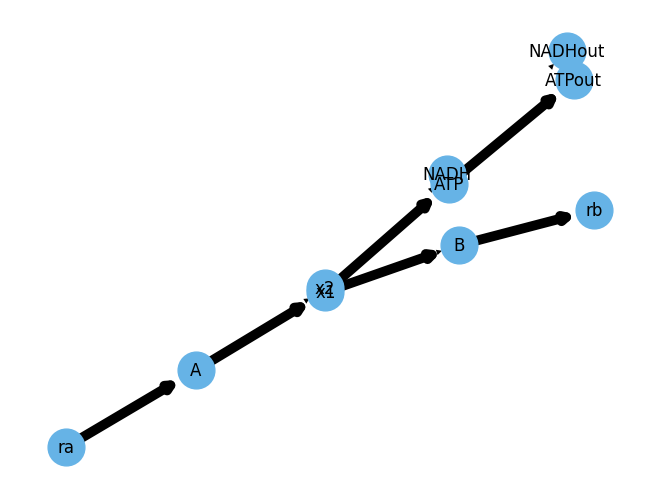

In [11]:
draw_network(S,reacs,metabs,solution)

In [ ]:
# Make it interactive

In [12]:
import plotly.graph_objects as go

In [14]:
def make_network(_S,_reacs,_metabs,_solution):
  flux_vec = _solution.x #  flux vector
  thickness_factor = 7
  norm_flux = thickness_factor*flux_vec /max(abs(flux_vec)) # Computes normalized flux vector for drawing network
  G = nx.DiGraph()
  G.add_nodes_from(_metabs)
  G.add_nodes_from(_reacs)
  for col in range(_S.shape[1]): 
    reac_string=_reacs[col] + "[Flux = "+ str(round(flux_vec[col],2)) + "] : "
    curr_col=_S[:, col]
    curr_col_pos= np.where(curr_col > 0)[0] 
    curr_col_neg= np.where(curr_col < 0)[0] 

    if len(curr_col_neg)>0:
      for f in curr_col_neg:
        G.add_edge(_metabs[f],_reacs[col],weight=norm_flux[col])    

    if len(curr_col_pos)>0:
      for f in curr_col_pos:
        G.add_edge(reacs[col],metabs[f],weight=norm_flux[col])

  return G

In [15]:
G = make_network(S,reacs,metabs,solution)

In [27]:
pos = nx.kamada_kawai_layout(G,weight=0)

In [31]:
pos['A']

array([-0.61139216, -0.21574726])

In [33]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [34]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Interactive Graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()